# <img style="float: left; padding-right: 10px; width: 150px" src="../../imagini/unitbv2.png"> SIIPA2020- Știința Explorării și Exploatării Datelor - ADS1  






## <center>Curs 10 - Clasificatori ML</center>
**Universitatea Transilvania**<br>
**Semestrul I, 2020-2021**<br>
**Instructor:** Conf. univ. dr. Teodor &Scedil;tefan B&icirc;ldea<br>
**Contact:** teodor.bildea@unitbv.ro<br>


## Scurtă recapitulare

Data trecută am văzut la lucru primul clasificator - regresia logistică.

Am văzut cum se evaluează un clasificator și am calculat metrici în acest sens:

- matricea de confuzie
- Precision, Recall, F1
- Curba ROC si metrica AUC

## Ce vom face în continuare

- Lucrul cu date de antrenament balansate și dezechilibrate
    > Eșantionare stratificată
- Clasificatori din scikit-learn
- Rgresori din scikit-learn

# Eșantionare stratificată

In clasificare antrenamentul depinde de ponderea claselor in setul de date. Pentru clasificare binara o pondere echilibrata, balansata, a celor doua clase in variabila tinta e rar intalnita. Adesea o clasa domina.

Pentru a surprinde proportia reala din clase setul de antrenament trebuie construi in asa fel incat sa respecte aceasta proportie. 

Sa presupunem ca dorim sa pastram 30% din date pentru test si antrenam pe 70% din date. 

Sa mai presupunem ca ponderea in setul initial este 60% clasa 1, 40% clasa 0. 

Pentru a regasi aceasta proportie in setul de antrenament ar trebuie sa separam setul de date in cel al clasei 1, sa alegem aleator 70% pentru antrenament, 30% pentru test. Apoi facem acelasi lucru cu clasa 0 si reunim seturile de antrenament intr-unul in care avem 70% din date iar ponderea e 60%  clasa 1 si 40% clasa 0. Aceasta este o esantionare stratificata.

Python ofera o solutie care sa realizeze cele de mai sus in mod automat:
`StratifiedShuffleSplit`

Solutia de mai sus face chiar mai multe decat am cerut. O vom folosi cu  `n_splits = 1` mai jos, unde `n_splits` este numarul de submultimi pe care le putem crea pentru validare incrucisata - in cazul nostru ne rezumam la o singura pereche train/test aleasa aleator.

### Exemplu
In exemplul de mai jos se studiaza in ce masure se poate determina predispozitia pentru diabet. Variabil tinta este coloana `label`. 

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']

# incarcare set de date
pima = pd.read_csv("pima-indians-diabetes.csv", header=0, names=col_names)

# instantiere clasa de esantionare stratificata
train_test_selector = StratifiedShuffleSplit(n_splits =1, test_size = 0.3, random_state = 77)

# bucla prin valorile variabilei target (in cazul nostru binare) pentru a construi seturile de train, test
for train_idx, test_idx in train_test_selector.split(pima,pima['label']):
    train_set = pima.loc[train_idx]
    test_set = pima.loc[test_idx]

print(train_set.shape[0] + test_set.shape[0], pima.shape[0])
display(train_set.head(5))
print('Proportie clase in setul initial: clasa 0 -', pima[pima.label ==0].shape[0]/pima.shape[0] )
print('Proportie clase in setul de antrenament: clasa 0 -', train_set[train_set.label ==0].shape[0]/train_set.shape[0] )
print('Proportie clase in setul de testare: clasa 0 - ', test_set[test_set.label ==0].shape[0]/test_set.shape[0] )

768 768


pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  label
714         3      102  74     0        0  29.5     0.121   32      0
328         2      102  86    36      120  45.5     0.127   23      1
530         2      122  60    18      106  29.8     0.717   22      0
4           0      137  40    35      168  43.1     2.288   33      1
389         3      100  68    23       81  31.6     0.949   28      0

Proportie clase in setul initial: clasa 0 - 0.6510416666666666
Proportie clase in setul de antrenament: clasa 0 - 0.6517690875232774
Proportie clase in setul de testare: clasa 0 -  0.6493506493506493


# Clasificare cu scikit learn

Scikit-Learn oferă acces facil la numeroși algoritmi de clasificare diferiți. Printre acești clasificatori se numără:

- K-Nearest Neighbors (cei mai apropiati K vecini)
- Support Vector Machines `SVM`(masini cu suport vectorial)
- Decision Tree Classifiers/Random Forests `RF`(arbori de decizie/paduri aleatoare)
- Naive Bayes

Vom discuta mai in detaliu 2 clasificatori: `SVM` si `RF`.
    

## K-Nearest Neighbors

KNN operează verificând distanța de la un exemplu de test până la valorile cunoscute ale unui exemplu de instruire. Grupul de puncte / clasă de date care ar oferi cea mai mică distanță între punctele de antrenament și punctul de testare este clasa selectată (mai precis clasa cu cele mai multe puncte apropiate de punctul de test pentru care se doreste clasificarea).

Parametru:

> $k$ - numarul de vecini considerati pentru a masura distantele si a obtine votul majoritar

De exemplu pentru $k=3$ se vor considera 3 vecini in setul de antrenament. Pentru clasificare binara asta inseamna ca cel putin doi dintre cei 3 cei mai apropiati vecini vor fi intr-o clasa astfel ca votul majoritar va fi obtinut.

> De retinut: 'modelul' in acest caz este intreg setul de date pentru ca in prognoza punctele noi vor fi comparate cu intreg setul de date pentru a gasi cei mai apropiati $k$ vecini. Asta inseamna ca modelul nu e foarte eficient - de fiecare data va calcula toate distantele si va ordona intregul set de distante pentru a gasi cei mai apropiati $k$ vecini.

În cele ce urmează  prezentăm modul general prin care testăm dacă un model produce rezultate.

Procedură:
- validare încrucișată. De multe ori este implementată alături de model. Acestea însă se pot aplica doar în cazul în care nu aveți operațiuni intermediare asupra datelor de antrenament. 

### ATENȚIE MARE: de exemplu dacă normalizați datele cu standard scaler
La validare încrucișată, la spargerea setului de date în 10 bucăți aleatoriu, se scoate pe rând una din submulțimi pentru evaluare. Pe cele 9 rămase se pregătește antrenamentul: se determină media si deviația standard, se normalizează datele - de exemplu pentru atributul $X_i$ din coloana $i$:

$$
\begin{align} 
\mu^{train}_i = \frac{1}{N-1}\sum_kX^{train}_{i,k}, \\
\sigma^{train}_i =\sqrt{\frac{\sum_k(X^{train}_{i,k}-\mu_i)^2}{N-1}}, \\
\widetilde{X^{train}_{i}}=\frac{(X^{train}_{i}-\mu^{train}_i)}{\sigma^{train}_i} 
\end{align}
$$

și datele normalizate $\widetilde{X^{train}_i}$ sunt folosite in modelare. Apoi datele de evaluare vor fi normalizate cu <b>aceeiași medie și deviație standard</b> $\mu^{train}_i, \sigma^{train}_i$, adică:
$$
\begin{align} 
\widetilde{X^{eval}_{i}}=\frac{(X^{eval}_{i}-\mu^{train}_i)}{\sigma^{train}_i}.
\end{align}
$$

La fel se întâmplă când aveți atribute derivate la nivel de date de antrenament - frecvențe, etc. De aceea e bine să folosiți cu grijă validările încrucișate oferite. Mai bine scrieți codul care vă ajută după cum am făcut în exemplul de mai jos.


## Exemplu clasificare kNN

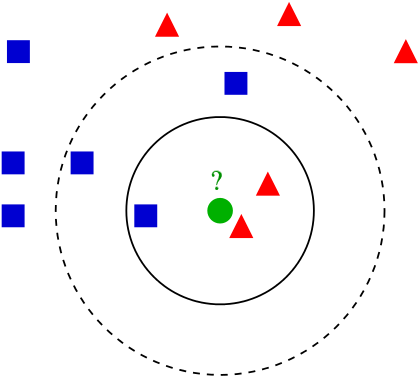



Credit <a href="https://commons.wikimedia.org/w/index.php?curid=2170282" class="dc by ii ij ik il" target="_blank" rel="noopener nofollow">Antti Ajanki AnAj</a>


In [2]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# incarcare set date
pima = pd.read_csv("pima-indians-diabetes.csv", header=0, names=col_names)

In [3]:
pima.head()

pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  label
0         6      148  72    35        0  33.6     0.627   50      1
1         1       85  66    29        0  26.6     0.351   31      0
2         8      183  64     0        0  23.3     0.672   32      1
3         1       89  66    23       94  28.1     0.167   21      0
4         0      137  40    35      168  43.1     2.288   33      1

In [4]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pregnant  768 non-null    int64  
 1   glucose   768 non-null    int64  
 2   bp        768 non-null    int64  
 3   skin      768 non-null    int64  
 4   insulin   768 non-null    int64  
 5   bmi       768 non-null    float64
 6   pedigree  768 non-null    float64
 7   age       768 non-null    int64  
 8   label     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
from sklearn.model_selection import StratifiedKFold
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)

Toate variabilele sunt numerice, nu avem null-uri, putem modela.

In [2]:
from numpy import mean
from numpy import std
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics as met

# instantiere clasa de esantionare stratificata - alege spargerea 10 pentru validare încrucișată
train_test_selector = StratifiedShuffleSplit(n_splits =10, test_size = 0.3)#, random_state = 77)
columns_for_training = [c for c in col_names if c!='label']

# pentru rezutate
res_train = []
res_test = []
# enumerare validări încrucișate
i = 1
for train_idx, test_idx in train_test_selector.split(pima,pima['label']):
    
    train_set = pima.loc[train_idx]
    test_set = pima.loc[test_idx]
    
    print(i, train_set.shape[0] + test_set.shape[0])
    
    # preparere variabila răspuns
    ytrain, ytest = train_set['label'], test_set['label']
    
    # preparare predictori
    Xtrain = train_set[columns_for_training].to_numpy()  
    Xtest = test_set[columns_for_training].to_numpy()
    
    # buclă după număr vecini
    for k in range(2,20):
        kNN_cslf = KNeighborsClassifier(n_neighbors=k)
        kNN_cslf.fit(Xtrain, ytrain)

        # fitting error
        y_fit_reg = kNN_cslf.predict(Xtrain)
        a=met.roc_auc_score(ytrain, y_fit_reg)
        res_train.append(({"cv_step":i,"k":k, "AUC":a}))
        
        # error on test - unseen data
        y_pred_reg = kNN_cslf.predict(Xtest)

        b=met.roc_auc_score(ytest, y_pred_reg)

        res_test.append({"cv_step":i,"k":k, "AUC":b})
    
    i = i + 1
    
display(pd.DataFrame(res_train))
display(pd.DataFrame(res_test))

1 768
2 768
3 768
4 768
5 768
6 768
7 768
8 768
9 768
10 768


cv_step   k       AUC
0          1   2  0.748663
1          1   3  0.787960
2          1   4  0.718846
3          1   5  0.754079
4          1   6  0.722032
..       ...  ..       ...
175       10  15  0.707196
176       10  16  0.713827
177       10  17  0.720932
178       10  18  0.696539
179       10  19  0.703461

[180 rows x 3 columns]

cv_step   k       AUC
0          1   2  0.608148
1          1   3  0.656914
2          1   4  0.638025
3          1   5  0.666420
4          1   6  0.665556
..       ...  ..       ...
175       10  15  0.723951
176       10  16  0.709259
177       10  17  0.719630
178       10  18  0.725926
179       10  19  0.739630

[180 rows x 3 columns]

In [6]:
import plotly.graph_objects as go
df=pd.DataFrame(res_test)

fig = go.Figure()
for cv_step in df.cv_step.unique():
    
    fig.add_trace(go.Scatter(x = df[df.cv_step==cv_step].k, y = df[df.cv_step==cv_step].AUC,
                           name = 'step '+str(cv_step)))


fig.show()

In [7]:
import plotly.express as px

fig = px.box(df, x="k", y="AUC")
fig.show()

Concluzie: cel mai bun $k$ este 7- după această valoare nu se mai înregistează mari modificări în metrica AUC (cu cât mai mare această valoare, cu atât mai bună).

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support

traindf, testdf = train_test_split(pima, test_size=0.2, random_state=42)

# preparere variabila răspuns
ytrain, ytest = traindf['label'], testdf['label']

# preparare predictori
Xtrain = traindf[columns_for_training].to_numpy()  
Xtest = testdf[columns_for_training].to_numpy()
kNN_cslf = KNeighborsClassifier(n_neighbors=7)

kNN_cslf.fit(Xtrain, ytrain)

# error on test - unseen data
y_pred = kNN_cslf.predict(Xtest)

precision_recall_fscore_support(ytest,y_pred)

(array([0.77419355, 0.55737705]),
 array([0.72727273, 0.61818182]),
 array([0.75     , 0.5862069]),
 array([99, 55], dtype=int64))

## Arbori de decizie

Un arbore de decizie funcționează prin descompunerea unui set de date în subseturi tot mai mici pe baza unor diferite criterii. Vor fi utilizate diferite criterii de sortare pentru a împărți setul de date, numărul de exemple fiind mai mic cu fiecare diviziune.

După ce rețeaua a împărțit datele la un singur exemplu, exemplul va fi pus într-o clasă care corespunde unei chei.


Un arbore de decizie este o structură de arbore asemănătoare cu fluxul în care un nod intern reprezintă o caracteristică (sau un atribut), ramura reprezintă o regulă de decizie și fiecare nod frunză reprezintă rezultatul. Cel mai înalt nod dintr-un arbore de decizie este cunoscut sub numele de nodul rădăcină. Învață să se partajeze pe baza valorii atributului. Partitionează arborele în mod recursiv, apelare partiționare recursivă. Această structură asemănătoare cu fluxul vă ajută în luarea deciziilor. Vizualizarea este ca o diagramă de diagramă care imită cu ușurință gândirea la nivel uman. De aceea, arborii de decizie sunt ușor de înțeles și de interpretat.

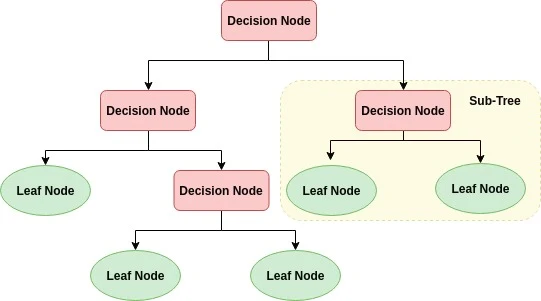

Arborele de decizii este un tip de algoritm white box - expus. Acesta împărtășește logica de luare a deciziilor interne, care nu este disponibilă în tipul de algoritmi black box, precum Rețea Neuronală. Timpul său de pregătire este mai rapid în comparație cu algoritmul rețelei neuronale. Complexitatea în timp a arborilor de decizie este o funcție a numărului de înregistrări și a numărului de atribute din datele date. Arborele decizional este o metodă fără distribuție sau non-parametrică, care nu depinde de presupunerile de distribuție a probabilității. Arborii de decizii pot trata datele de înaltă dimensiune cu o precizie bună.

> Problema cea mai mare este bias-ul sau sensitivitatea la schimbari in valorile atributelor.

### Cum funcționează algoritmul ?
Ideea de bază din spatele oricărui algoritm de arbore de decizie este următoarea:

- Selecteaza cel mai bun atribut folosind măsuri de selecție a atributelor (ASM) pentru a împărți înregistrările.
- Fa din acel atribut un nod de decizie și sparge setul de date în submultimi mai mici.
- Începe construirea arborilor prin repetarea acestui proces recursiv pentru fiecare copil până când una dintre urmatoarele se va potrivi:
    - Toate inregistrarile aparțin aceleiași valori de atribut.
    - Nu mai există alte atribute.
    - Nu mai există cazuri.
    
- se poate impune o adancime maxima pentru a evita overfitting. 

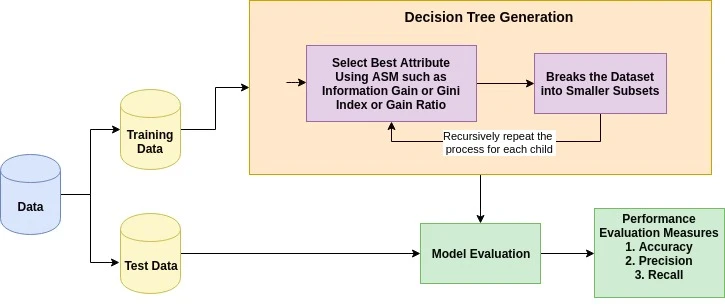

### Măsuri de selecție a atributelor (ASM)
Măsura de selecție a atributelor este o euristica pentru selectarea criteriului optim de partiționare. Este, de asemenea, cunoscut sub numele de reguli de divizare, deoarece ne ajută să determinăm punctele de întrerupere pentru tuple pe un nod dat. ASM oferă un rang fiecărei caracteristici (sau atribute) prin explicarea setului de date dat. Cel mai bun atribut de scor va fi selectat ca atribut de divizare. În cazul unui atribut cu valoare continuă, punctele împărțite pentru ramuri trebuie, de asemenea, definite. Cele mai populare măsuri de selecție sunt câștigul de informații (Information Gain), rata de câștig (Gain Ratio) și indicele Gini (Gini Index).

In exemplul de mai jos se studiaza in ce masure se poate determina predispozitia pentru diabet. Variabil tinta este coloana `label`. 

In [9]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [10]:
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
# incarcare set date
pima = pd.read_csv("pima-indians-diabetes.csv", header=0, names=col_names)

In [11]:
pima.head()

pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  label
0         6      148  72    35        0  33.6     0.627   50      1
1         1       85  66    29        0  26.6     0.351   31      0
2         8      183  64     0        0  23.3     0.672   32      1
3         1       89  66    23       94  28.1     0.167   21      0
4         0      137  40    35      168  43.1     2.288   33      1

### Selectarea atributelor informative (feature selection)
Aici, trebuie să împărțiți coloanele date în două tipuri de variabile dependente (sau variabile țintă) și variabilă independentă (sau variabile caracteristice sau covariatele).

In [12]:
#split dataset in features and target variable
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = pima[feature_cols] # Features
y = pima.label # Target variable

### Împărțirea datelor
Pentru a înțelege performanța modelului, împărțirea setului de date într-un set de antrenament și un set de teste este o strategie bună.

Să împărțim setul de date utilizând funcția train_test_split (). Trebuie să treceți 3 parametrii:
- X:covariatele
- y: variabila target/tinta 
- proportia setul de test in setul initial.


In [13]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=1) # 70% training and 30% test

Să creăm un model de arbore de decizie folosind Scikit-learning.

In [14]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

Evaluarea modelului creat

In [15]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


Să comparăm cu antrenare unui model kNN cu $k=7$.

In [17]:
knn_clf =KNeighborsClassifier(n_neighbors=7)
# Train Decision Tree Classifer
knn_clf = knn_clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = knn_clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy kNN(k=7):",metrics.accuracy_score(y_test, y_pred))

Accuracy kNN(k=5): 0.7705627705627706


## TEMA 1

Reprezentati grafic curba ROC si calculati AUC pentru acest clasificator - arbore de decizie.
> **Hint** - vedeti ce alte proprietati in afara de `metrics.accuracy_score` are obiectul `metrics` si cum se folosesc.

Ei bine, ați obținut o rată de clasificare de 66,66%. Puteți îmbunătăți această precizie prin reglarea parametrilor din algoritm.

### Vizualizarea arborilor de decizie
Puteți utiliza funcția export_graphviz Scikit-learning pentru afișarea arborelui într-un notebook Jupyter. Pentru arborele de clasificare, trebuie să instalați și python-graphviz și pydotplus.




In [18]:
import os
os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/Library/bin/graphviz/bin/'

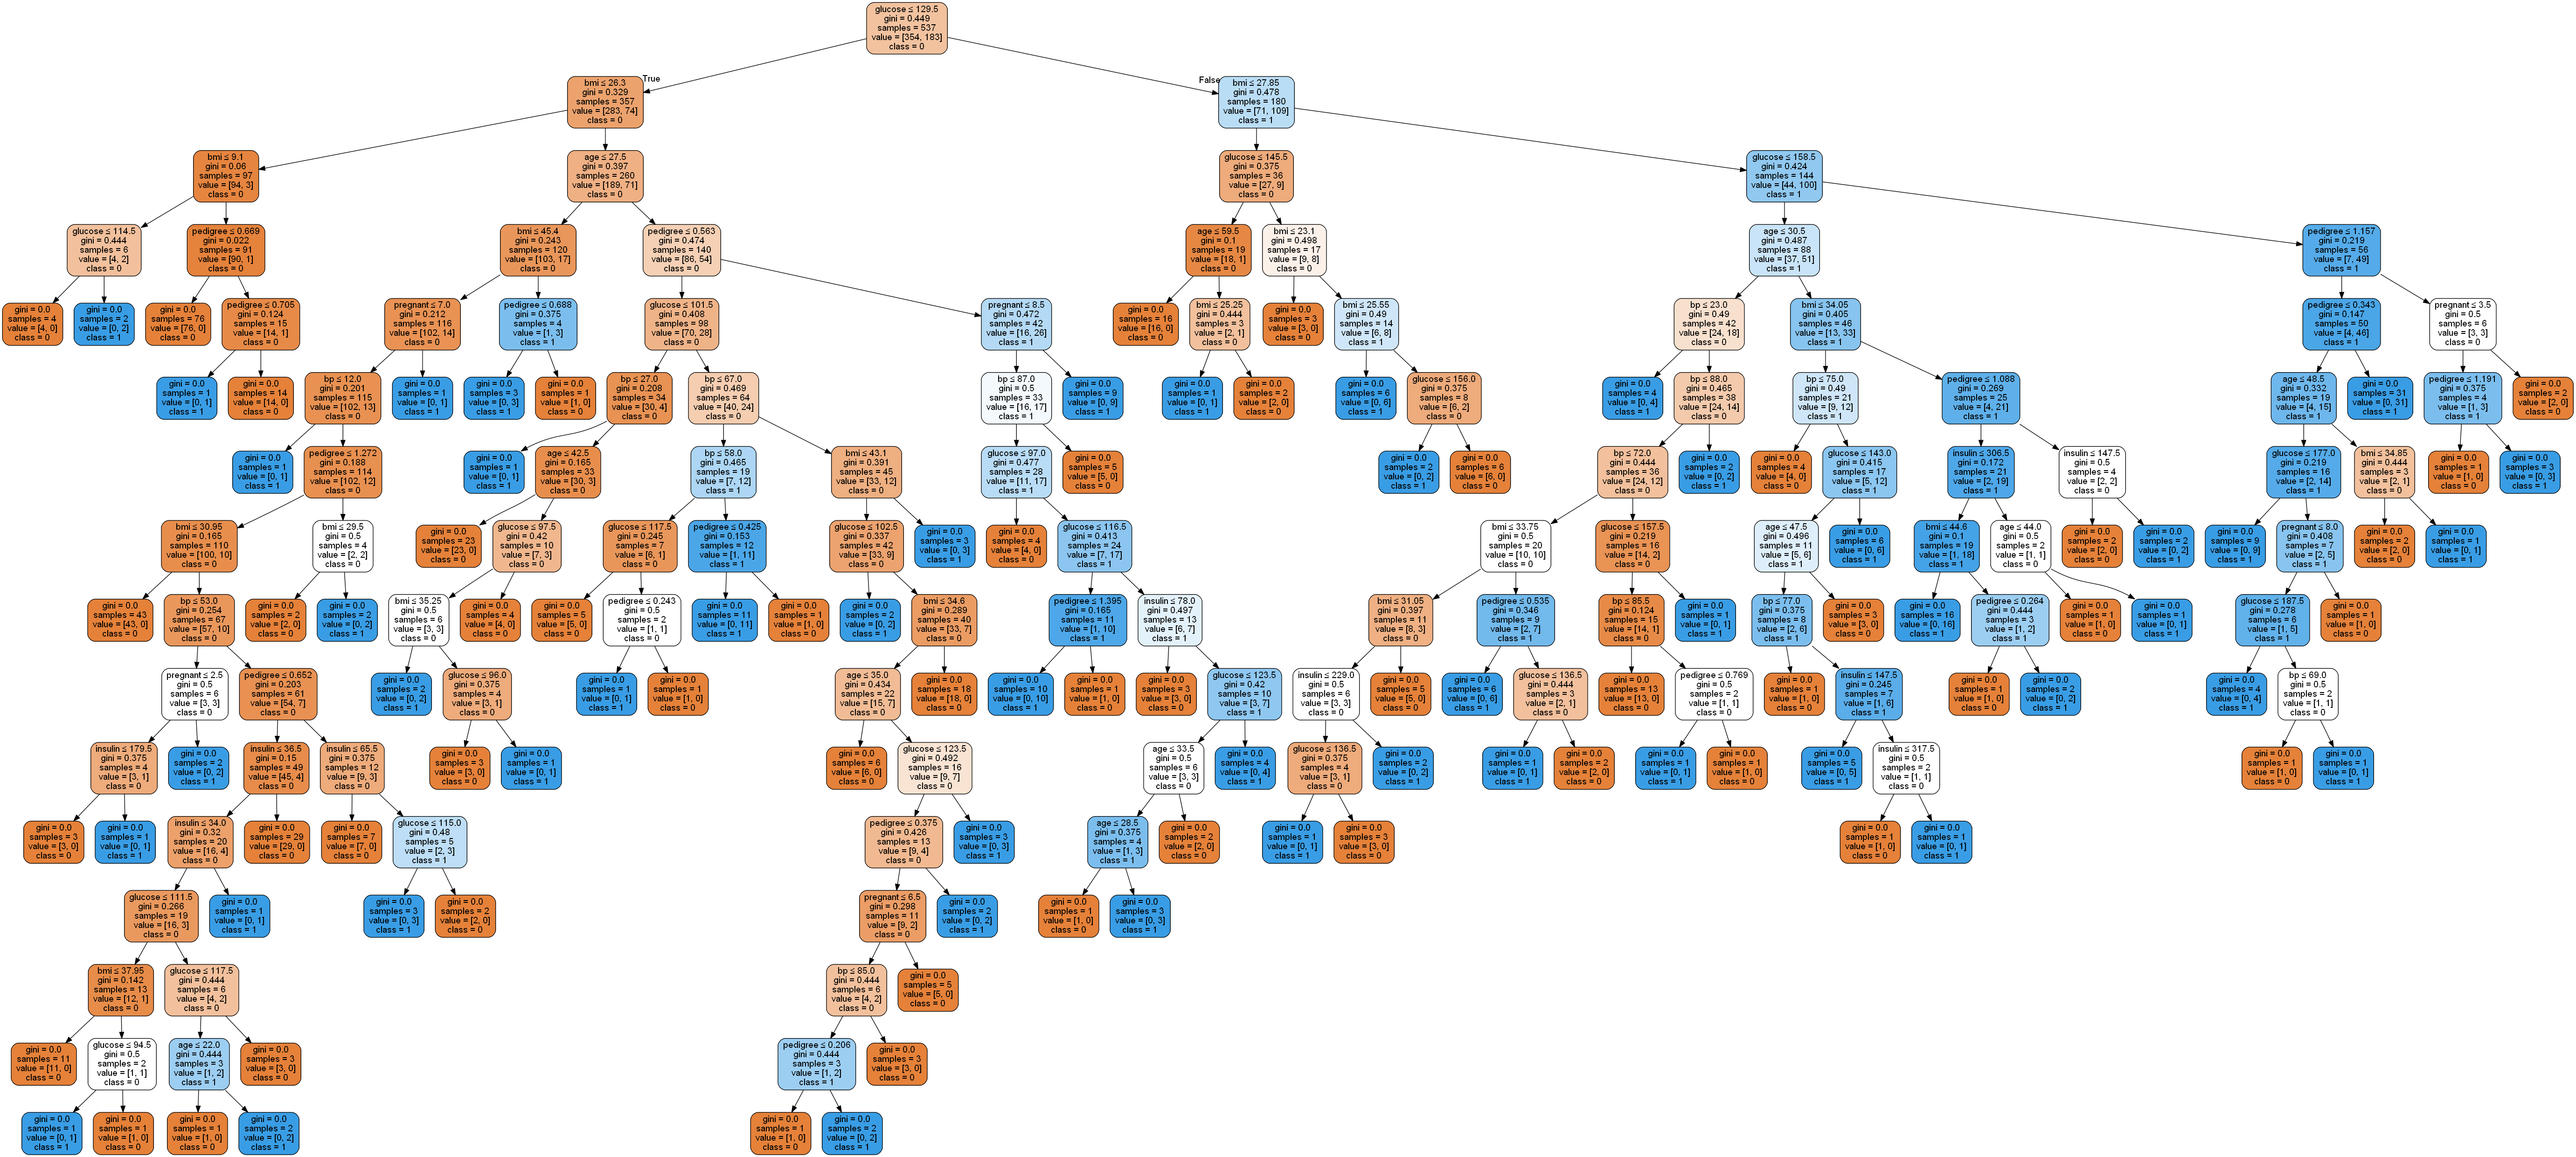

In [19]:
from six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn import tree
dot_data = StringIO()
tree.export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())


# Parametrii
Cu ajutorul codului urmator puteti sa explorati efectul diferitelor atribute asupra structurii arborelui de decizie.

Parametrii sunt:
- criterion: Funcția de a măsura calitatea unei splitari. Criteriile acceptate sunt „gini” pentru Gini impurity index și „entropie” pentru Information Gain.

- splitter: Strategia folosită pentru a alege împărțirea la fiecare nod. Strategiile acceptate sunt „best” pentru a alege cea mai bună împărțire și „random” pentru a alege cea mai bună divizare aleatorie.

- max_depth: Adâncimea maximă a copacului. Dacă e setat pe `None`, atunci nodurile sunt extinse până când toate frunzele sunt pure sau până când toate frunzele conțin mai puțin de `min_samples_split` mostre.

- min_samples_split: Numărul minim de eșantioane necesar pentru a împărți un nod intern:

      - Dacă e un număr intreg, atunci acesta va fi considerat drept numărul minim de esantioane.

      - Dacă e un float (numar real), atunci min_samples_split este o proportie, iar plafonul (min_samples_split * n_samples) este numărul minim de probe pentru fiecare împărțire.

- min_samples_leaf: Numărul minim de eșantioane necesar să fie la un nod frunze. O ramificație la orice adâncime va fi luată în considerare numai dacă lasă cel puțin min_samples_leaf eșantioane în fiecare dintre ramurile din stânga și din dreapta. Aceasta poate avea efectul de a netezi modelul, în special în regresie.

In [20]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
# # load dataset
# data = load_wine()
# # feature matrix
# X = data.data
# # target vector
# y = data.target
# class labels
labels = feature_cols

def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = DecisionTreeClassifier(random_state = 0 
          , criterion = crit
          , splitter = split
          , max_depth = depth
          , min_samples_split=min_split
          , min_samples_leaf=min_leaf)
    estimator.fit(X, y)
    y_pred = estimator.predict(X_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    graph = Source(tree.export_graphviz(estimator
          , out_file=None
          , feature_names=labels
          , class_names=['0', '1']
          , filled = True))

    display(SVG(graph.pipe(format='svg')))
    return estimator,

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[1,2,3,4,5,6]
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))
display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

Acest model toaletat (pruned) este mai puțin complex, explicabil și ușor de înțeles decât modelul precedent de model de arbore de decizie.

### Avantaje

- Arborii de decizie sunt ușor de interpretat și vizualizat.
- Poate captura cu ușurință modele neliniare.
- Este nevoie de mai puține preprocesări de date de la utilizator, de exemplu, nu este necesară normalizarea coloanelor.
- Poate fi utilizat pentru ingineria caracteristicilor, cum ar fi prezicerea valorilor lipsă, potrivite pentru selecția variabilă.
- Arborele decizional nu are presupuneri cu privire la distribuția din cauza naturii non-parametrice a algoritmului. (Sursă)

###  Dezavantaje

- Date sensibile la zgomot. Se pot potrivi cu date zgomotoase.
- Variația mică (sau variația) din date poate duce la arbori de decizie diferiti. 
- Arborii de decizie sunt afectati de un set de date cu clase dezechilibrate, de aceea este recomandat să echilibrezi setul de date înainte de a crea arborele de decizie

# Random Forest Classifier

Cum functioneaza:
- Se selecteaza eșantioane aleatorii dintr-un set de date dat.
- Se construieste un arbore de decizie pentru fiecare eșantion și se obinte un rezultat de predicție din fiecare arbore de decizie.
- Se acorda un vot pentru fiecare rezultat prevăzut.
- Se selecteaza rezultatul predicției cu cele mai multe voturi ca predicție finală.

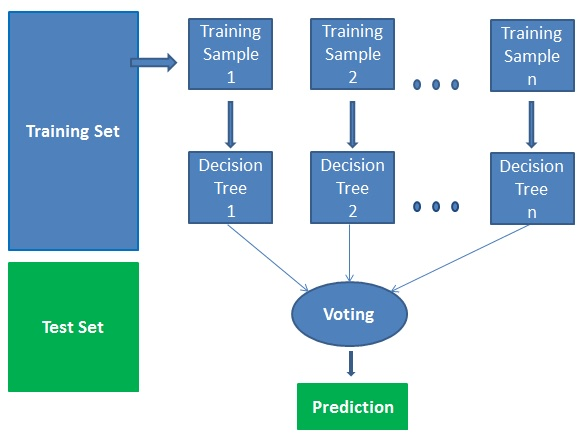

### Avantaje
- Pădurile aleatoare sunt considerate o metodă extrem de precisă și robustă datorită numărului de arbori de decizie care participă la proces.
- Nu suferă de problema de overfit sau bias. Motivul principal este că este nevoie de media tuturor predicțiilor, ceea ce anulează specificatea setului de date (bias/prejudecăți).
- Algoritmul poate fi utilizat atât în problemele de clasificare cât și în cele de regresie.
- Pădurile aleatoare pot gestiona, de asemenea, valorile lipsă. Există două modalități de gestionare a acestora: folosirea valorilor mediane pentru a înlocui variabilele continue și calcularea mediei ponderate de proximitate a valorilor lipsă.
- Puteți obține importanța relativă a caracteristicilor, ceea ce ajută la selectarea celor mai importante atribute pentru clasificator.

### Dezavantaje
- Pădurea aleatoare generează lent predicții, deoarece are mai mulți arbori de decizie. Ori de câte ori face o predicție, toți copacii din pădure trebuie să facă o predicție pentru același input dat și apoi să efectueze votul asupra acesteia. Tot acest proces necesită mult timp.
- Modelul este dificil de interpretat în comparație cu un arbore de decizie, unde puteți lua cu ușurință o decizie urmând calea din arbore.


### Parametrii

Prezentam in continuare cativa dintre parametrii implementarii din <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html" class="dc by ii ij ik il" target="_blank" rel="noopener nofollow">scikit-learn</a>

- n_estimators: Numărul de arbori din pădure.

- criterion: Funcția de a măsura calitatea unei splitari. Criteriile acceptate sunt „gini” pentru Gini impurity index și „entropie” pentru Information Gain.

- max_depth: Adâncimea maximă a copacului. Dacă e `None`, atunci nodurile sunt extinse până când toate frunzele sunt pure sau până când toate frunzele conțin mai puțin de min_samples_split mostre.

- min_samples_split: (implicit = 2) Numărul minim de eșantioane necesar pentru a împărți un nod intern:

    - Dacă e un număr intreg, atunci acesta va fi considerat drept numărul minim de esantioane.

    - Dacă e un float (numar real), atunci min_samples_split este o proportie, iar plafonul (min_samples_split * n_samples) este numărul minim de probe pentru fiecare împărțire.



- min_samples_leaf: Numărul minim de eșantioane necesar să fie la un nod frunze. Un punct despărțit la orice adâncime va fi luat în considerare numai dacă lasă cel puțin min_samples_leaf probe de formare în fiecare dintre ramurile din stânga și din dreapta. Aceasta poate avea efectul de a netezi modelul, în special în regresie.

    - Dacă e int, atunci consideră min_samples_leaf drept numărul minim.

    - Dacă e float, atunci min_samples_leaf este o fracție, iar plafonul (min_samples_leaf * n_samples) este numărul minim de eșantioane pentru fiecare nod.

- min_weight_fraction_leaf: Fracția minimă ponderată din suma totală a greutăților (din toate eșantioanele de intrare) necesară pentru a fi la un nod frunze. Probele au o greutate egală atunci când nu este furnizat eșantion_weight.

- max_features: int, float, string sau None, opțional (implicit = "auto") Numărul de caracteristici care trebuie luate în considerare atunci când căutați cea mai bună împărțire:

    - Dacă int, atunci se iau în considerare max_features la fiecare împărțire.

    - Dacă float, atunci max_features este o proportie și sunt considerate caracteristici int (max_features * n_features) la fiecare împărțire.

    - Dacă „auto”, atunci max_features = sqrt (n_features).

    - Dacă „sqrt”, atunci max_features = sqrt (n_features) (la fel ca „auto”).

    - Dacă „log2”, max_features = log2 (n_features).

    - Dacă Niciuna, atunci max_features = n_features.

> Notă: căutarea unei împărțiri nu se oprește până când nu este găsită cel puțin o partiție validă a eșantioanelor nodului, chiar dacă este necesară inspecția eficientă a mai multor funcții max_features.


In [21]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

După divizare, veți antrena modelul pe setul de antrenament și veți face predicții pe setul de testare.


In [46]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
import numpy
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=200, max_samples= 0.2,
                          #max_features =int(round(0.33*Xtrain.shape[1],0))
                          )
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [47]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7835497835497836


La fel ca si al arborii de decizie, si aici putem considera evaluarea clasificatorului cu curba ROC si AUC, dar si metricile Precision, Recall, F1 pentru un prag de 0.5 pentru scorul dat de random forest.

# Tema 2

- curba ROC, AUC
- Recall, Precision, F1

# SVM classifier